Here we use a simple k-means clustering to show the neurons that fire together

In [1]:
import os
from skimage.io import imread
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
MAX_IMAGES = 800
DOWNSCALE_FACTOR = 2
with np.load('../input/flo_image_1.npz') as im_data:
    image_dict = dict(zip(im_data['image_ids'], im_data['image_stack'][:MAX_IMAGES, ::DOWNSCALE_FACTOR, ::DOWNSCALE_FACTOR]))
print('Loaded',len(image_dict), 'images')

Loaded 800 images


In [3]:
time_df = pd.read_csv('../input/data141110.csv')
time_df['path'] = time_df['Image.No.'].map(lambda x: "141110A3.%04d" % (x))
time_df['loaded'] = time_df['path'].map(lambda x: x in image_dict)
valid_time_df = time_df.query('loaded')
valid_time_df.sample(3)

,Image.No.,Frame.No,Time.hrs.,path,loaded
598,648,599,63.416306,141110A3.0648,True
591,641,592,62.716306,141110A3.0641,True
13,61,14,4.922628,141110A3.0061,True


# Assemble the data
Here we assemble the data into a 3D stack ordered by time for further analysis

In [4]:
ordered_im_stack = np.stack([image_dict[c_path] for c_path in valid_time_df.sort_values('Time.hrs.')['path'].values],0)

# Show an montage overview of the whole stack

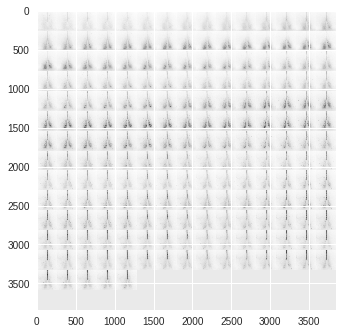

In [5]:
from skimage.util.montage import montage2d
plt.imshow(montage2d(ordered_im_stack[::4]))

In [6]:
# unwrap the pixel positions so we have just the time observations
time_vec = ordered_im_stack.reshape(ordered_im_stack.shape[0], -1)

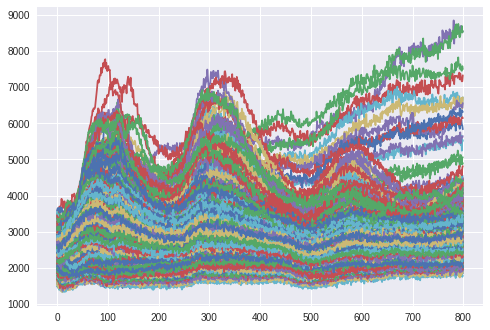

In [7]:
# show the various time courses
_ = plt.plot(time_vec[:,::100])

# K-Means Clustering
Here we cluster the temporal data by time to make a better representation of the image

In [8]:
from sklearn.cluster import KMeans
n_kmc = KMeans(n_clusters = 6)

In [9]:
%%time
# apply the kmeans clustering
n_kmc.fit(time_vec.T)

CPU times: user 5min 3s, sys: 1min 4s, total: 6min 7s
Wall time: 3min 31s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Show Clusters
Here we show the clusters as a new image, the regions colored the same, have the same time-course of activation and thus fire together. 

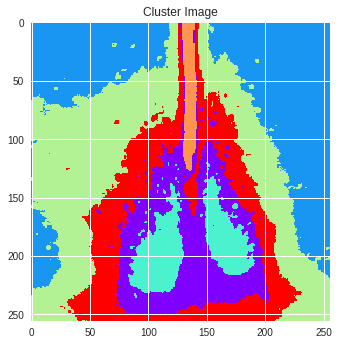

In [10]:
cluster_vec = n_kmc.predict(time_vec.T)
cluster_img = cluster_vec.reshape(ordered_im_stack.shape[1:])
fig, ax1 = plt.subplots(1,1)
ax1.imshow(cluster_img, cmap = 'rainbow')
ax1.set_title('Cluster Image')

## Time Behavior of Each Cluster
Here we take each cluster and show the temporal behavior. This lets us show more clearly the differences between groups and see if there are groups which are phase-shifted from others which might indicate a sequential firing pattern

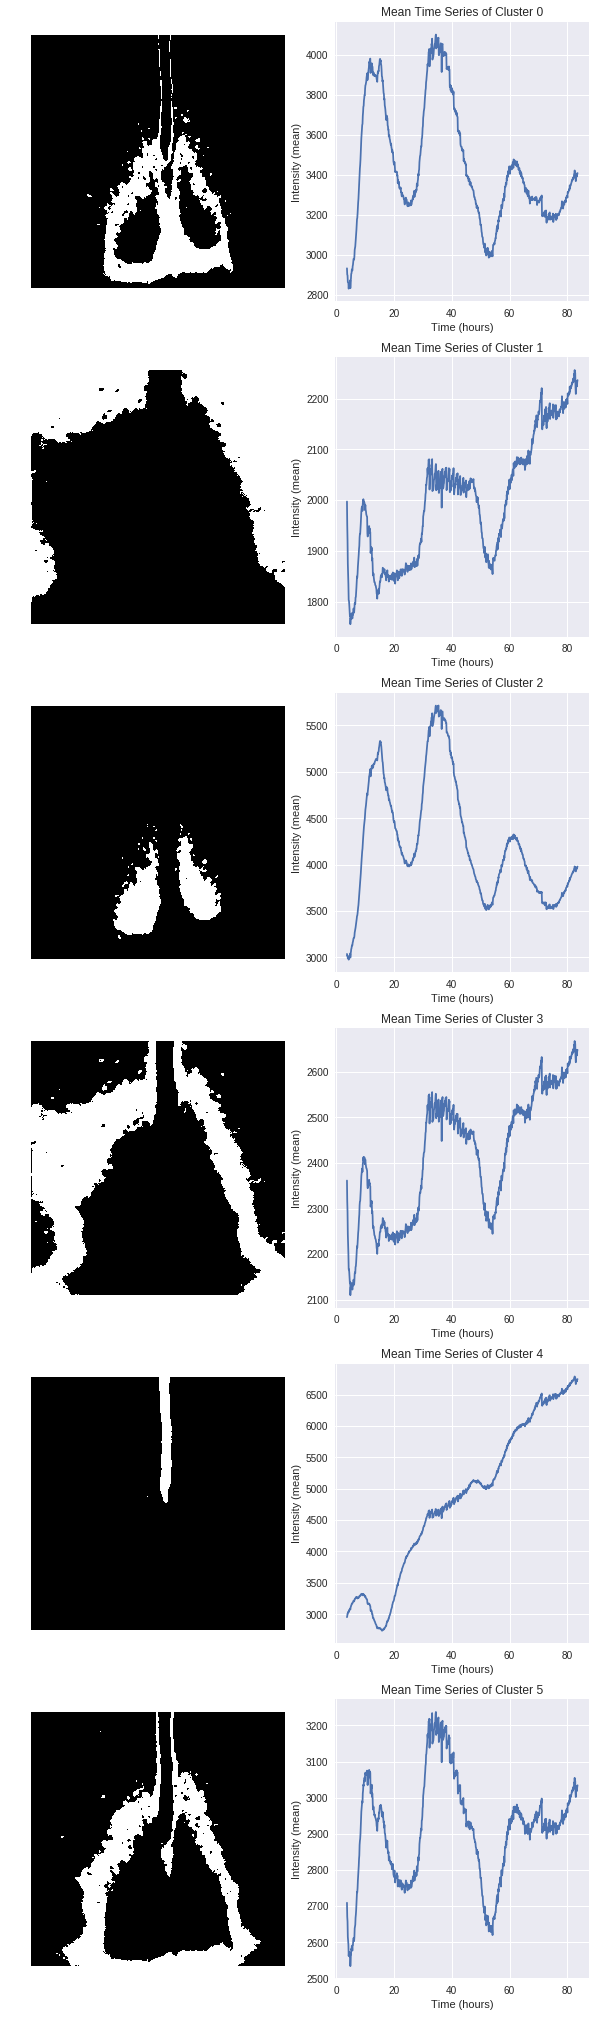

In [11]:
cluster_ids = np.unique(cluster_vec)
fig, m_axs = plt.subplots(len(cluster_ids), 2, figsize = (10, len(cluster_ids)*6))
for (im_ax, c_ax) , idx in zip(m_axs, cluster_ids):
    im_ax.imshow(cluster_img == idx, cmap = 'bone')
    im_ax.axis('off')
    c_ax.set_title('Image of Cluster {}'.format(idx))
    c_ax.plot(
        valid_time_df['Time.hrs.'],
        np.mean(time_vec[:,cluster_vec == idx],1))
    c_ax.set_title('Mean Time Series of Cluster {}'.format(idx))
    c_ax.set_xlabel('Time (hours)')
    c_ax.set_ylabel('Intensity (mean)')